# Take 1

In [9]:
from collections import deque

In [17]:
# Step 1 - Input
width = int(input("What is the width of the matrix? "))
height = int(input("What is the height of the matrix? "))
num_shapes = int(input("What is the number of shapes? "))

What is the width of the matrix? 40
What is the height of the matrix? 40
What is the number of shapes? 11


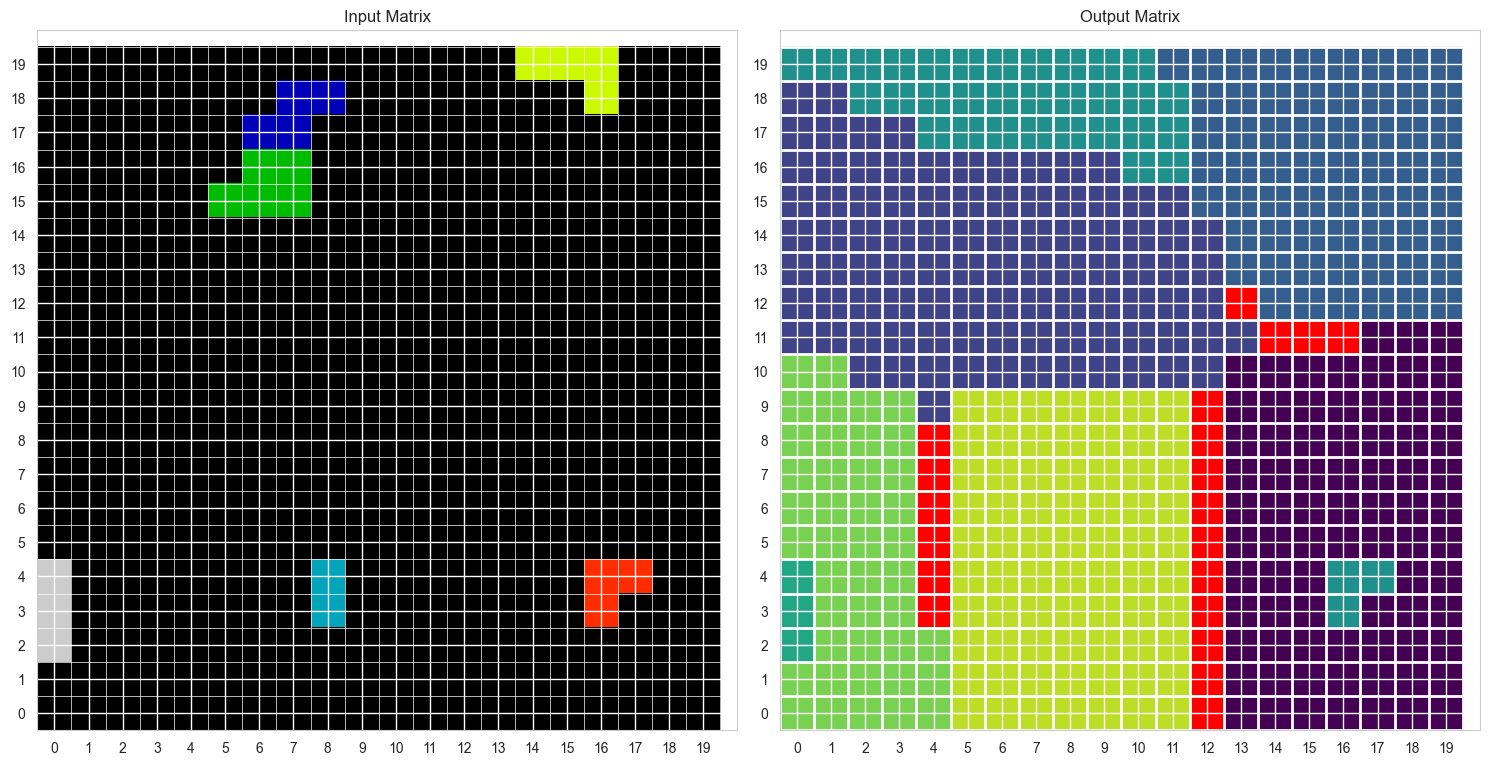

In [103]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import distance_transform_edt
import matplotlib.pyplot as plt
import numpy as np



def generate_shapes(width, height, num_shapes):
    matrix = np.zeros((height, width), dtype=int)
    directions = [(0, 1), (1, 0), (0, -1), (-1, 0)]  # Right, Down, Left, Up

    for shape_id in range(1, num_shapes + 1):
        # Start with a single seed point
        while True:
            x, y = np.random.randint(width), np.random.randint(height)
            if matrix[y, x] == 0:
                matrix[y, x] = shape_id
                break

        # Determine the shape size randomly
        shape_size = np.random.randint(1, 5)

        for _ in range(shape_size):
            np.random.shuffle(directions)  # Randomize directions
            for dx, dy in directions:
                nx, ny = x + dx, y + dy
                if 0 <= nx < width and 0 <= ny < height and matrix[ny, nx] == 0:
                    x, y = nx, ny  # Move to the new position
                    matrix[y, x] = shape_id
                    break

    return matrix

def calculate_output_matrix(input_matrix, num_shapes):
    height, width = input_matrix.shape
    output_matrix = np.full((height, width), -1)  # Start with -1 as a default value for non-background pixels
    
    # Initialize a dictionary to track unique shape IDs
    shape_id_mapping = {}
    next_unique_id = 1
    
    # Calculate distance maps for each shape
    distance_maps = []
    for shape_id in range(1, num_shapes + 1):
        distance_map = distance_transform_edt(input_matrix != shape_id)
        distance_maps.append(distance_map)
    
    # For each background pixel, find the closest shape
    for y in range(height):
        for x in range(width):
            if input_matrix[y, x] == 0:  # It's a background pixel
                distances = [distance_maps[shape_id-1][y, x] for shape_id in range(1, num_shapes + 1)]
                min_distance = min(distances)
                closest_shapes = [shape_id for shape_id, dist in enumerate(distances, 1) if dist == min_distance]
                
                if len(closest_shapes) == 1:
                    # Only one closest shape
                    closest_shape_id = closest_shapes[0]
                    if closest_shape_id not in shape_id_mapping:
                        shape_id_mapping[closest_shape_id] = next_unique_id
                        next_unique_id += 1
                    output_matrix[y, x] = -shape_id_mapping[closest_shape_id]
                else:
                    # Equidistant to multiple shapes, leave it as 0 to mark as red later
                    output_matrix[y, x] = 0

    # Copy the original shapes onto the output matrix with unique negative IDs
    for shape_id in range(1, num_shapes + 1):
        if shape_id not in shape_id_mapping:
            shape_id_mapping[shape_id] = next_unique_id
            next_unique_id += 1
        output_matrix[input_matrix == shape_id] = -shape_id_mapping[shape_id]
    
    return output_matrix

def plot_matrices(input_matrix, output_matrix, num_shapes):
    
    # Obtain width and height from the input matrix shape
    height, width = input_matrix.shape
    fig_width = 15  # Adjust the size as needed
    fig_height = fig_width * (height / width)

    fig, ax = plt.subplots(1, 2, figsize=(fig_width, fig_height), dpi=100)

    # Define a color map for shapes with darker colors
    shape_colors = plt.cm.viridis(np.linspace(0.5, 1, num_shapes))

    # Define a color map for distances with lighter colors
    distance_colors = plt.cm.viridis(np.linspace(0, 0.5, num_shapes))

    # Stack the shape and distance color maps
    all_colors = np.vstack((shape_colors, distance_colors))

    # Create a new color map from the stacked colors
    new_color_map = plt.matplotlib.colors.ListedColormap(all_colors)
    # Define a color map for shapes with black for the background and other colors for shapes
    shape_colors = [(0, 0, 0)] + [plt.cm.nipy_spectral(i / num_shapes) for i in range(1, num_shapes+1)]
    color_map_shapes = plt.matplotlib.colors.ListedColormap(shape_colors)

    for ax_idx in range(2):
        # Set major ticks for grid lines at whole numbers
        ax[ax_idx].set_xticks(np.arange(0, width, 1))
        ax[ax_idx].set_yticks(np.arange(0, height, 1))

        # Set grid to only appear on major tick marks
        ax[ax_idx].grid(which='major', color='white', linestyle='-', linewidth=1)

        # Set the aspect of the plot to 'equal' to ensure squares are 1x1
        ax[ax_idx].set_aspect('equal')

        # Set the limits of the plot to the size of the matrix
        ax[ax_idx].set_xlim([0, width])
        ax[ax_idx].set_ylim([0, height])

        # Turn off minor ticks to clean up the plot
        ax[ax_idx].tick_params(which='minor', size=0)
        ax[ax_idx].tick_params(which='major', size=5)
    # Plot input matrix
    ax[0].imshow(input_matrix, cmap=color_map_shapes, interpolation='none', aspect='equal')
    ax[0].set_title('Input Matrix')
    ax[0].axis('on')
    ax[0].set_xticks(np.arange(-.5, width, 1), minor=True)
    ax[0].set_yticks(np.arange(-.5, height, 1), minor=True)
    ax[0].grid(which='minor', color='white', linestyle='-', linewidth=0.5)
    ax[0].tick_params(which='minor', size=0)
    ax[0].set_aspect('equal')

     # Modify output matrix to have lighter shades for the closest shape
    output_visual = np.zeros_like(output_matrix)
    for shape_id in range(1, num_shapes + 1):
        shape_mask = input_matrix == shape_id
        distance_mask = output_matrix == -shape_id
        output_visual[shape_mask] = shape_id - 1  # Darker color for shapes
        output_visual[distance_mask] = shape_id + num_shapes - 1  # Lighter color for distances

    # Find equidistant points and mark them
    equidistant_points = output_matrix == 0
    equidistant_color_index = 2 * num_shapes  # Index for equidistant points (red)
    output_visual[equidistant_points] = equidistant_color_index

    # Add the red color for equidistant points
    equidistant_color = np.array([[1.0, 0.0, 0.0, 1.0]])  # Red
    all_colors_with_red = np.vstack((all_colors, equidistant_color))
    color_map_with_red = plt.matplotlib.colors.ListedColormap(all_colors_with_red)



    # Plot output matrix
    ax[1].imshow(output_visual, cmap=color_map_with_red, interpolation='none', aspect='equal')
    ax[1].set_title('Output Matrix')
    ax[1].axis('on')
    ax[1].set_xticks(np.arange(-.5, width, 1), minor=True)
    ax[1].set_yticks(np.arange(-.5, height, 1), minor=True)
    ax[1].grid(which='minor', color='white', linestyle='-', linewidth=2)
    ax[1].set_aspect('equal')

    plt.tight_layout()
    plt.show()


# Example usage
input_matrix = generate_shapes(20, 20, 6)  
output_matrix = calculate_output_matrix(input_matrix, 6)  
plot_matrices(input_matrix, output_matrix,6)

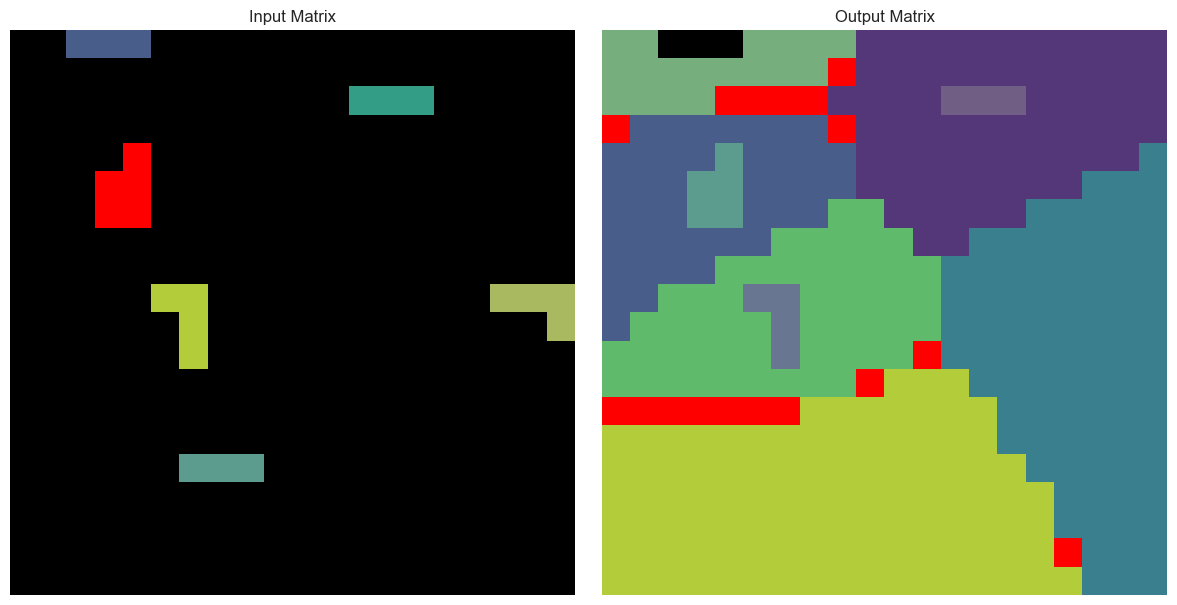

In [104]:
import numpy as np
import matplotlib.pyplot as plt

def create_color_maps(num_shapes):
    # Generate a colormap excluding the first and last 10% to avoid dark and red colors
    base_colors = plt.cm.viridis(np.linspace(0.1, 0.9, num_shapes))

    # Darken the shape colors for the input matrix
    input_shape_colors = base_colors * 0.7
    # Lighten the base colors for distances in the output matrix
    distance_colors = base_colors * 0.9

    # Add black for the background and red for equidistant points
    black = np.array([[0, 0, 0, 1]])  # Black color for background
    red = np.array([[1.0, 0.0, 0.0, 1]])  # Red color for equidistant points

    # Combine all the colors into a single colormap
    combined_colors = np.vstack((black, input_shape_colors, distance_colors, red))
    return plt.matplotlib.colors.ListedColormap(combined_colors)



def plot_input_matrix(matrix, colormap, ax):
    # Create a visualization matrix for the input
    input_visual = np.zeros((matrix.shape[0], matrix.shape[1], 4))
    for shape_id in np.unique(matrix)[1:]:  # Skip the background (0)
        input_visual[matrix == shape_id] = colormap(shape_id)
    ax.imshow(input_visual, interpolation='none', aspect='equal')
    ax.set_title('Input Matrix')
    ax.axis('off')

def plot_output_matrix(matrix, colormap, ax):
    # Create a visualization matrix for the output
    output_visual = np.zeros((matrix.shape[0], matrix.shape[1], 4)) + colormap(0)  # Start with the background color
    unique_distances = np.unique(matrix[matrix < 0])
    for dist in unique_distances:
        output_visual[matrix == dist] = colormap(num_shapes + np.abs(dist))
    # Red for equidistant points
    output_visual[matrix == 0] = colormap(-1)
    ax.imshow(output_visual, interpolation='none', aspect='equal')
    ax.set_title('Output Matrix')
    ax.axis('off')

def visualize_matrices(input_matrix, output_matrix, num_shapes):
    colormap = create_color_maps(num_shapes)
    fig, axs = plt.subplots(1, 2, figsize=(12, 6), dpi=100)

    # Input Matrix Visualization
    input_visual = np.zeros(input_matrix.shape)
    for shape_id in range(1, num_shapes + 1):
        input_visual[input_matrix == shape_id] = shape_id

    # Assign black color to background pixels
    input_visual[input_visual == 0] = -1

    axs[0].imshow(input_visual, cmap=colormap, interpolation='none', aspect='equal')
    axs[0].set_title('Input Matrix')
    axs[0].axis('off')

    # Output Matrix Visualization
    output_visual = np.zeros(output_matrix.shape)
    for shape_id in range(1, num_shapes + 1):
        output_visual[output_matrix == -shape_id] = num_shapes + shape_id
        output_visual[input_matrix == shape_id] = shape_id

    # Assign red color to equidistant points
    equidistant_color_index = 2 * num_shapes + 1
    output_visual[output_matrix == 0] = equidistant_color_index

    axs[1].imshow(output_visual, cmap=colormap, interpolation='none', aspect='equal')
    axs[1].set_title('Output Matrix')
    axs[1].axis('off')

    plt.tight_layout()
    plt.show()


# Example usage
width, height, num_shapes = 20, 20, 6
input_matrix = generate_shapes(width, height, num_shapes)  # Replace with actual function to generate shapes
output_matrix = calculate_output_matrix(input_matrix, num_shapes)  # Replace with actual function to calculate the output
visualize_matrices(input_matrix, output_matrix, num_shapes)


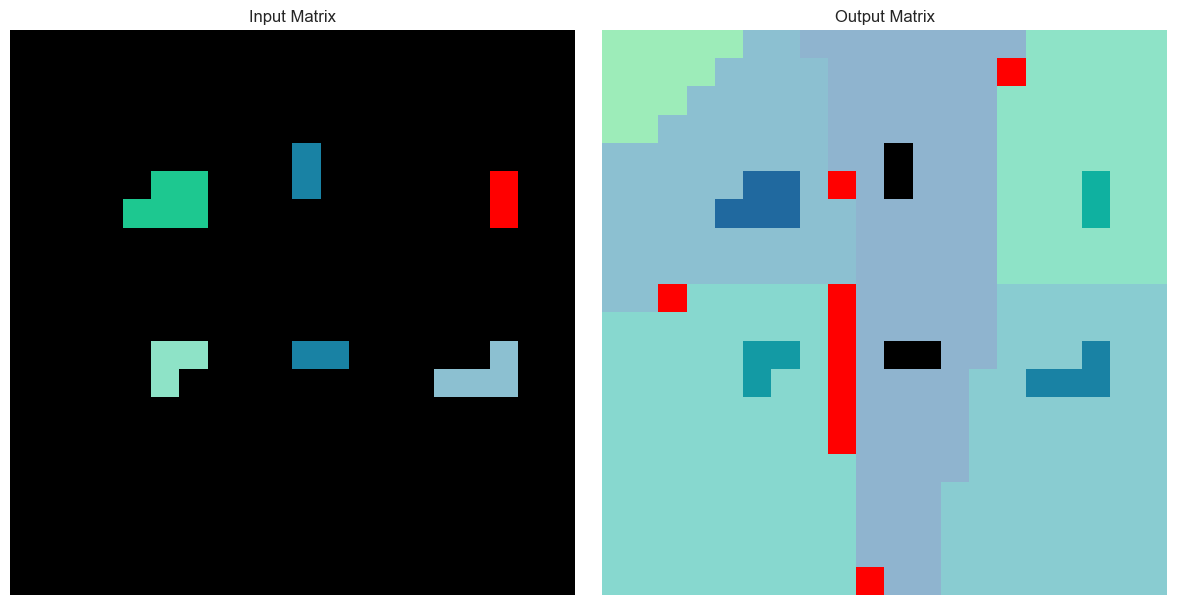

In [81]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

def create_color_maps(num_shapes):
    # Generate a colormap that excludes red and dark colors
    base_colors = plt.cm.viridis(np.linspace(0.2, 0.8, num_shapes))

    # Avoid colors too close to black and red by adjusting the luminance and removing the red channel
    shape_colors = base_colors.copy()
    shape_colors[:, 0] = shape_colors[:, 0] * 0.5  # Reduce red channel
    shape_colors[:, 1:] = shape_colors[:, 1:] * 0.8 + 0.2  # Increase green and blue channels

    # Create lighter shades for the surrounding colors in the output matrix
    lighter_colors = shape_colors + (1 - shape_colors) * 0.5

    # Add black for the background and red for equidistant points
    black = np.array([[0, 0, 0, 1]])  # Black color for background
    red = np.array([[1.0, 0.0, 0.0, 1]])  # Red color for equidistant points

    # Combine colors into a single colormap
    combined_colors = np.vstack((black, shape_colors, lighter_colors, red))
    return ListedColormap(combined_colors)

def visualize_matrices(input_matrix, output_matrix, num_shapes):
    colormap = create_color_maps(num_shapes)
    fig, axs = plt.subplots(1, 2, figsize=(12, 6), dpi=100)

    # Input Matrix Visualization
    input_visual = np.where(input_matrix > 0, input_matrix, 0)

    # Output Matrix Visualization
    output_visual = np.where(output_matrix < 0, num_shapes + np.abs(output_matrix), input_matrix)
    output_visual[output_matrix == 0] = num_shapes * 2 + 1  # Index for red color in colormap

    axs[0].imshow(input_visual, cmap=colormap, interpolation='none', aspect='equal')
    axs[0].set_title('Input Matrix')
    axs[0].axis('off')

    axs[1].imshow(output_visual, cmap=colormap, interpolation='none', aspect='equal')
    axs[1].set_title('Output Matrix')
    axs[1].axis('off')

    plt.tight_layout()
    plt.show()

# Example usage
width, height, num_shapes = 20, 20, 6
input_matrix = generate_shapes(width, height, num_shapes)  # Replace with actual function to generate shapes
output_matrix = calculate_output_matrix(input_matrix, num_shapes)  # Replace with actual function to calculate the output
visualize_matrices(input_matrix, output_matrix, num_shapes)

